## Split wavs to source level, append to title source, elevation, azimuth

In [ ]:
# from pydub import AudioSegment
# import os
# import pandas as pd

# # Input
# annotations = pd.read_csv("D:\\units\\PML\\project\\metadata_dev\\meta_of_meta.csv")

# for i in range(0,len(annotations)):
#     sound = AudioSegment.from_wav(os.getcwd() + '\\mic_dev\\' + annotations.iloc[i, 0] + '.wav')
#     StrtTime = annotations.iloc[i, 2]*1000
#     EndTime = annotations.iloc[i, 3]*1000
#     # Opening file and extracting portion of it
#     extract = sound[StrtTime:EndTime]
#     # Saving file in required location
#     extract.export("D:\\units\\PML\\project\\mic_dev_splits\\" + annotations.iloc[i, 1] + "_" + str(annotations.iloc[i, 5]) + "_" + str(annotations.iloc[i, 6]) + "_" +  str(i) + ".wav", format="wav")

In [45]:
!pip3 install -U pip

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'C:\Users\LENOVO\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.



     ---------------------------------------- 2.1/2.1 MB 6.5 MB/s eta 0:00:00


In [46]:
!pip3 install scikit-image

In [47]:
import skimage
print(skimage.__version__)

0.19.3


In [37]:
import os
import numpy as np 
import matplotlib.pyplot as plt 

from pydub import AudioSegment
import wave

import librosa
import librosa.display

import skimage.io 



## Data Exploration

Baic info on audios, checking uniformity on sample_rate

In [ ]:
# Load files
audio_segment_1 = AudioSegment.from_file("D:\\units\\PML\\project\\mic_dev_splits\\clearthroat_10_20_36.wav")
audio_segment_2 = AudioSegment.from_file("D:\\units\\PML\\project\\mic_dev_splits\\keyboard_0_100_63.wav")
audio_segment_3 = AudioSegment.from_file("D:\\units\\PML\\project\\mic_dev_splits\\phone_-40_-30_27.wav")

audio_segments = [audio_segment_1, audio_segment_2, audio_segment_3]

# Print attributes
for audio_segment in audio_segments:
    print(f"Channels: {audio_segment.channels}")
    print(f"Sample width: {audio_segment.sample_width}")
    print(f"Frame rate (sample rate): {audio_segment.frame_rate}")
    print(f"Frame width: {audio_segment.frame_width}")
    print(f"Length (ms): {len(audio_segment)}")
    print(f"Frame count: {audio_segment.frame_count()}")
    print(f"Intensity: {audio_segment.dBFS}")

Plotting different amplitudes

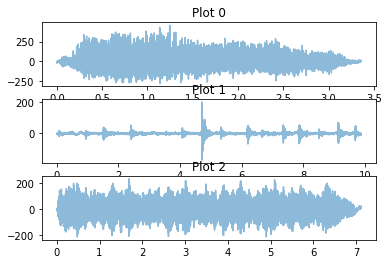

In [3]:
# Open wav file and read frames as bytes
sf_filewave_1 = wave.open('D:\\units\\PML\\project\\mic_dev_splits\\clearthroat_10_20_36.wav', 'r')
sf_filewave_2 = wave.open('D:\\units\\PML\\project\\mic_dev_splits\\keyboard_0_100_63.wav', 'r')
sf_filewave_3 = wave.open('D:\\units\\PML\\project\\mic_dev_splits\\phone_-40_-30_27.wav', 'r')

sf_filewaves = [sf_filewave_1, sf_filewave_2, sf_filewave_3]

# Set up plot
f, axs = plt.subplots(3)
# Setup the title and axis titles
counter = 0
for sf_filewave in sf_filewaves:
    signal_sf = sf_filewave.readframes(-1)
    # Convert audio bytes to integers
    soundwave_sf = np.frombuffer(signal_sf, dtype='int16')
    # Get the sound wave frame rate
    framerate_sf = sf_filewave.getframerate()
    # Find the sound wave timestamps
    time_sf = np.linspace(start=0,
                        stop=len(soundwave_sf)/framerate_sf,
                        num=len(soundwave_sf))
    ax = axs[counter]
    # Add the audio data to the plot
    ax.plot(time_sf, soundwave_sf, label='Sound', alpha=0.5)
    ax.set_title(f'Plot {counter}')
    counter = counter + 1

plt.show()

## Feature extraction 

Trying with usual features, but would be hard to handle the continuous ones.

In [31]:
y, sr = librosa.load("D:\\units\\PML\\project\\clearthroat_-10_-60_19.wav")

# Get RMS value from each frame's magnitude value
# S, phase = librosa.magphase(librosa.stft(y))
features = librosa.feature.rms(y = y)[:, 0:4]
for path in os.listdir(dir_path):
    y, sr = librosa.load(dir_path + path)

    # Get RMS value from each frame's magnitude value
    # S, phase = librosa.magphase(librosa.stft(y))
    rms = librosa.feature.rms(y = y)
    features = np.vstack((features, rms[:, 0:4]))


In [32]:
print(features.shape)

(73, 4)


Going with the spectrogram and decided to work with the images.

In [ ]:
def wav_to_spectrogram():
    for filename in os.listdir(os.getcwd() + '/mic_dev_splits/'):
        if filename.endswith(".wav"): 
            x, sr = librosa.load(os.getcwd() + '/mic_dev_splits/' + filename)
            x_1k = librosa.resample(x, orig_sr=sr, target_sr=1000)
            # Spectrogram of frequency
            X = librosa.stft(x_1k)
            Xdb = librosa.amplitude_to_db(abs(X))
            plt.figure(figsize=(15, 3))
            librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz',cmap='gray_r')
            #plt.colorbar()
            plt.axis('off')
            plt.savefig(os.getcwd() + '/mic_dev_splits_imgs_1k/' + filename[0:-4] + '.png')
        else:
            continue

wav_to_spectrogram()

In [108]:
from skimage import io
img1 = io.imread('D:\\units\\PML\\project\\mic_dev_splits_imgs_1k\\laughter_-10_-10_31.png')
img2 = io.imread('D:\\units\\PML\\project\\mic_dev_splits_imgs_1k\\phone_10_-120_2.png')
print(np.array_equal(img1,img2))
data = np.empty((73,233280))
for filename in os.listdir(os.getcwd() + '/mic_dev_splits_imgs_1k/'):
    if filename.endswith(".wav"): 
        img = io.imread(os.getcwd() + '/mic_dev_splits_imgs_1k/' + filename)
        img1ch = img[..., 1]
        img1ch1d = img1ch.flatten()
        data = np.vstack((data, img1ch1d))      
    else:
        continue

print(data.shape)
print(data)


False
(73, 233280)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Get labels in respective arrays

In [104]:
# folder path
dir_path = r'D:\\units\\PML\\project\\mic_dev_splits\\'
first = "clearthroat_-10_-60_19"
ls1 = first.split("_")
# list to store files
source = []
elev = np.empty([1, 1])
elev.fill(int(ls1[1]))
azi = np.empty([1, 1])
azi.fill(int(ls1[2]))

# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        ls = path.split("_")
        source.append(ls[0])
        elev = np.append(elev,int(ls[1]))
        azi = np.append(azi, int(ls[2]))

In [105]:
print(elev.shape)
print(azi.shape)

source

(73,)
(73,)


['clearthroat',
 'clearthroat',
 'clearthroat',
 'clearthroat',
 'cough',
 'cough',
 'cough',
 'cough',
 'cough',
 'cough',
 'cough',
 'doorslam',
 'doorslam',
 'doorslam',
 'doorslam',
 'drawer',
 'drawer',
 'drawer',
 'drawer',
 'drawer',
 'drawer',
 'keyboard',
 'keyboard',
 'keyboard',
 'keyboard',
 'keyboard',
 'keyboard',
 'keyboard',
 'keysDrop',
 'keysDrop',
 'keysDrop',
 'keysDrop',
 'knock',
 'knock',
 'knock',
 'knock',
 'knock',
 'knock',
 'knock',
 'knock',
 'knock',
 'laughter',
 'laughter',
 'laughter',
 'laughter',
 'laughter',
 'laughter',
 'laughter',
 'laughter',
 'laughter',
 'laughter',
 'pageturn',
 'pageturn',
 'pageturn',
 'pageturn',
 'phone',
 'phone',
 'phone',
 'phone',
 'phone',
 'phone',
 'phone',
 'phone',
 'phone',
 'phone',
 'speech',
 'speech',
 'speech',
 'speech',
 'speech',
 'speech',
 'speech']